In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Additional code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
from pprint import pprint
from skimage.color import label2rgb
from skimage.filters import threshold_otsu, threshold_li

import degradation_utils as hp
from calculate_degradation import fetch_all_components_degradation

# Inputs

day
- filename = "b1d0091f-75824d0d.jpg"  
- filename = "b1d4b62c-60aab822.jpg"
- filename = "b5b02b31-f19988fb.jpg"

night
- filename = "b1ebfc3c-740ec84a.jpg"
- filename = "b6bdb46e-3709d206.jpg"
- filename = "b1d22449-117aa773.jpg"

other:
- filename = "0f68f127-05ff709b.jpg"

In [2]:
# path for image and mask
img_dir = "../segmentation/data/bdd100k/images/val/"
mask_dir = "../segmentation/data/bdd100k/generated_masks_v0_1/val/"

segments_output_dir = "./output/segments/"
annotations_output_dir = "./output/annotations/"

# BEV output size 
bev_transform_shape = (640, 640)

filename = "b5b02b31-f19988fb.jpg"

# filtering hyperparameters
min_area = 100
min_transform_area = 0.6
min_segment_dimension = 4

# degradation calculation hyperparameters
component_len_limit = 100     # length of a lane above which degradatrion needs to be calculated in parts
bin_length = 80               # length of a single part
relax_threshold = 0.05        # percentage of the calculated threshold to reduce to relax the good pixel creterion 

mask_name = ".".join(filename.split(".")[:-1]) + ".png"

In [3]:
# ensure all necessary folders are available
os.makedirs(segments_output_dir, exist_ok=True)
os.makedirs(annotations_output_dir, exist_ok=True)

img_path = os.path.join(img_dir, filename)
mask_path = os.path.join(mask_dir, mask_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_img = cv2.imread(mask_path)
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
mask_img = mask_img / 255
mask_img = mask_img.astype(np.uint8)

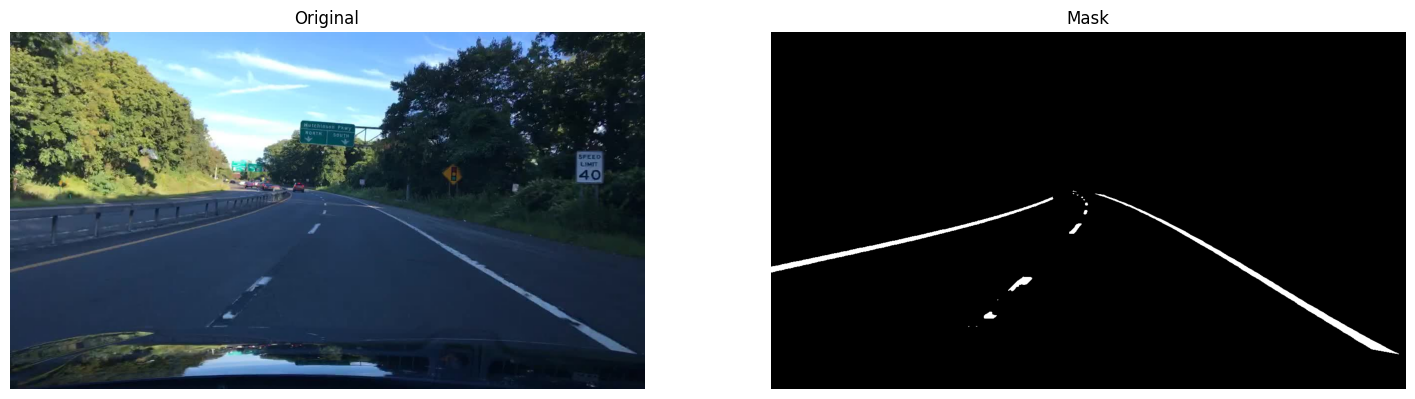

In [4]:
# visualize inputs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original")

ax[1].imshow(mask_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Mask")

plt.show()

# plt.figure(figsize=(20,5))
# plt.imshow(img)
# plt.imshow(mask_img, alpha=0.2, cmap="Reds")
# plt.show()

# Perspective Transform

In [5]:
# generate connected components
num_labels, label_mask, bboxes = hp.generate_connected_components(mask_img, connectivity=8)

# get ROI for transformation
roi_points = hp.get_roi_points()

# filtering of smaller components and components with less overlap with roi
filtered_label_mask = hp.filter_connected_components(label_mask=label_mask, roi_points=roi_points, min_area=min_area, min_roi_overlap=min_transform_area)
count = len(np.unique(filtered_label_mask))

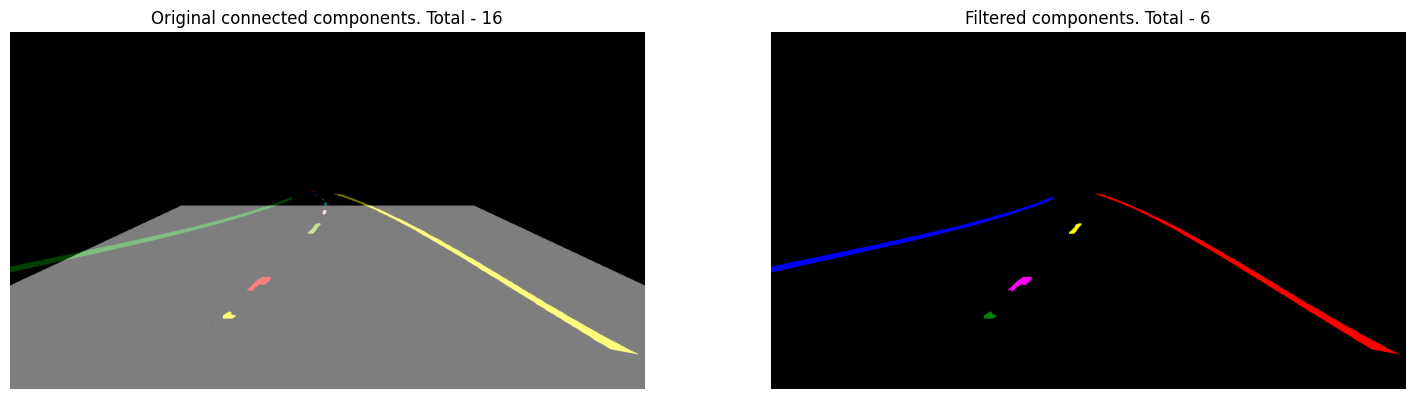

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

temp = np.zeros(label_mask.shape[:2])
temp = cv2.fillPoly(temp, pts=[roi_points], color=1).astype(np.uint8)

ax[0].imshow(label2rgb(label_mask))
ax[0].imshow(temp, cmap="gray", alpha=0.5)
ax[0].axis("off")
ax[0].set_title(f"Original connected components. Total - {num_labels}")

ax[1].imshow(label2rgb(filtered_label_mask))
ax[1].axis("off")
ax[1].set_title(f"Filtered components. Total - {count}")

plt.show()

In [7]:
# get transformation matrix
matrix = hp.generate_perspective_matrix(roi_pts=roi_points, output_shape=bev_transform_shape)

# Apply transformation on image
img_bev = hp.apply_perspective_transform(img=img.copy(), matrix=matrix, output_shape=bev_transform_shape, interpolation=cv2.INTER_NEAREST)

# Apply transformation on labelled mask
filtered_label_mask_bev = hp.apply_perspective_transform(img=filtered_label_mask.copy(), matrix=matrix, output_shape=bev_transform_shape, interpolation=cv2.INTER_NEAREST)

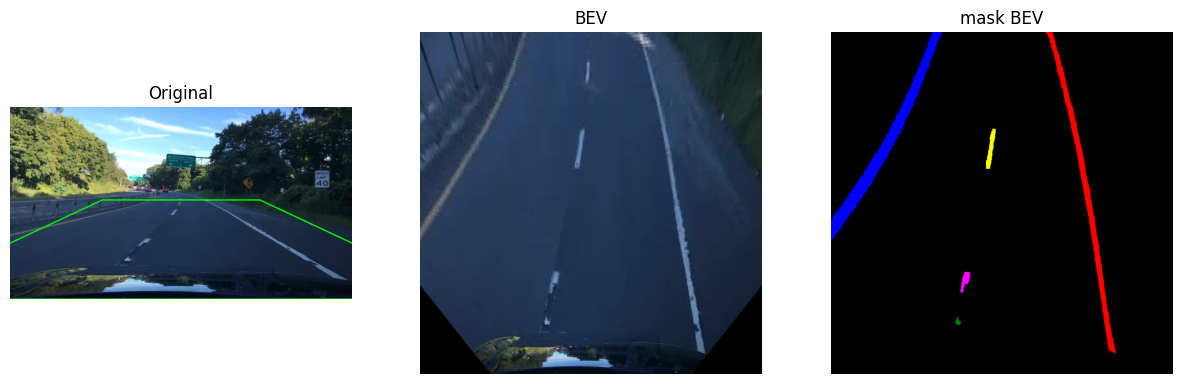

In [8]:
points = np.array(roi_points, np.int32)
d_points = points.reshape((-1, 1, 2))

# visualize transformation
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

oimg = img.copy()
oimg = cv2.polylines(oimg, [d_points], isClosed=True, color=(0, 255, 0), thickness=3)
ax[0].imshow(oimg)
ax[0].axis("off")
ax[0].set_title("Original")

ax[1].imshow(img_bev)
ax[1].axis("off")
ax[1].set_title("BEV")

colored_label_mask = label2rgb(filtered_label_mask_bev, bg_label=0)
ax[2].imshow(colored_label_mask)
ax[2].axis("off")
ax[2].set_title("mask BEV")

plt.show()

# Degradation Ratio Calculations

In [9]:
# converting image to grayscale
gray_img_bev = cv2.cvtColor(img_bev, cv2.COLOR_RGB2GRAY)

In [14]:
# Loop over each component (skip label 0, which is the background)
segment_labels = []
annot_results = []

component_degradation = fetch_all_components_degradation(gray_img=gray_img_bev, label_mask=filtered_label_mask_bev)

save_name = ".".join(filename.split(".")[:-1])  # remove extension

# Loop over each component (skip label 0, which is the background)
segment_labels = []
annot_results = []
for idx in range(1, num_labels):

    degradation_ratio = component_degradation.get(idx, -1)   # get degradation ratio (-1 if not calculated)
    coco_bbox = bboxes[idx].tolist()   # get bbox
    
    # if either dimension is less that required set ratio to -1
    if coco_bbox[2] < min_segment_dimension or coco_bbox[3] < min_segment_dimension:
        degradation_ratio = -1

    # save separate segment as png if degradation ratio is calculated
    if degradation_ratio >= 0:
        xmin, ymin, xmax, ymax = hp.box_coco_to_corner(coco_bbox)

        # get segment in original image
        orig_mask = (label_mask == idx).astype(np.uint8)
        segment = cv2.bitwise_and(img, img, mask=orig_mask)         # apply mask
        segment = segment[ymin:ymax + 1, xmin:xmax + 1].copy()      # get specific segment crop

        # Write the segment to the output dir
        segment_name = f"{save_name}_{idx}.png"
        segment_path = os.path.join(segments_output_dir, segment_name)
        cv2.imwrite(segment_path, cv2.cvtColor(segment, cv2.COLOR_RGB2BGR))

        segment_info = {
            "name": segment_name,
            'degradation': degradation_ratio,
            'ymax': ymax
        }
        segment_labels.append(segment_info)

    # store annotations
    mask_dict = {
        'id': idx,
        'bounding_box': coco_bbox,
        'degradation': degradation_ratio
    }
    annot_results.append(mask_dict)
    
annotations_dict = {
    'image': filename,
    'annotations': annot_results
}

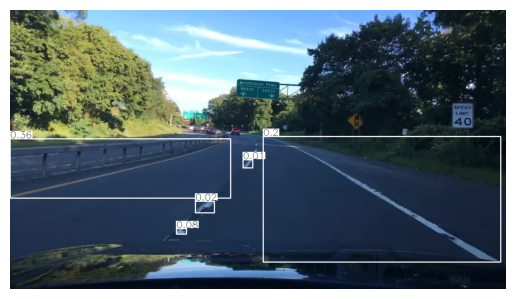

In [15]:
# visualize results
temp = img.copy()
for component in annot_results:
    ratio = component["degradation"]
    bbox = component["bounding_box"]
    if ratio < 0:
        continue
    bbox = hp.box_coco_to_corner(bbox)
    temp = hp.add_bbox(img=temp, bbox=bbox, label=f"{round(ratio, 2)}", font_scale=0.8)

plt.imshow(temp)
plt.axis("off")
plt.show()

In [16]:
# segment label csv
segment_df = pd.DataFrame(segment_labels)
segment_df.head()

,name,degradation,ymax
0,b5b02b31-f19988fb_3.png,0.2046,650
1,b5b02b31-f19988fb_5.png,0.3598,485
2,b5b02b31-f19988fb_10.png,0.0126,407
3,b5b02b31-f19988fb_11.png,0.0185,523
4,b5b02b31-f19988fb_13.png,0.0816,578


In [17]:
# image wise json
json_out_path = os.path.join(annotations_output_dir, f"{save_name}.json")
with open(json_out_path, 'w') as jspot:
    json.dump(annotations_dict, jspot)

annotations_dict

{'image': 'b5b02b31-f19988fb.jpg',
 'annotations': [{'id': 1,
   'bounding_box': [608, 320, 8, 3],
   'degradation': -1},
  {'id': 2, 'bounding_box': [608, 325, 3, 2], 'degradation': -1},
  {'id': 3, 'bounding_box': [653, 326, 613, 324], 'degradation': 0.2046},
  {'id': 4, 'bounding_box': [616, 328, 4, 2], 'degradation': -1},
  {'id': 5, 'bounding_box': [0, 332, 569, 153], 'degradation': 0.3598},
  {'id': 6, 'bounding_box': [625, 332, 4, 3], 'degradation': -1},
  {'id': 7, 'bounding_box': [629, 337, 4, 3], 'degradation': -1},
  {'id': 8, 'bounding_box': [633, 344, 6, 6], 'degradation': -1},
  {'id': 9, 'bounding_box': [630, 359, 8, 9], 'degradation': -1},
  {'id': 10, 'bounding_box': [601, 386, 25, 21], 'degradation': 0.0126},
  {'id': 11, 'bounding_box': [478, 493, 49, 30], 'degradation': 0.0185},
  {'id': 12, 'bounding_box': [456, 539, 2, 2], 'degradation': -1},
  {'id': 13, 'bounding_box': [429, 564, 26, 14], 'degradation': 0.0816},
  {'id': 14, 'bounding_box': [398, 593, 2, 2], 'de

## Single component degradation regions

In [ ]:
component_idx = 3
component_idx = min(component_idx, num_labels)

# Create a mask for the current object
component_mask = (filtered_label_mask_bev == component_idx).astype(np.uint8)   

# dilate the mask to include surrounding road region near lane marking for calculating threshold
dilate_kernel = 13
kernel = np.ones((dilate_kernel, dilate_kernel))
dilated_mask = cv2.dilate(component_mask, kernel, iterations=1)

# use this dialted region to get neighboring road color info
road_plus_lane = cv2.bitwise_and(gray_img_bev, gray_img_bev, mask=dilated_mask)

# crop given component from the grayscale image using mask
component_region = cv2.bitwise_and(gray_img_bev, gray_img_bev, mask=component_mask)

# placeholder to label each pixel as good or bad
type_mask = component_mask.copy()

# if lane is too long calculate degradation by dividing in horizontal bins
non_zero_y, non_zero_x = np.nonzero(component_mask)
ymin, ymax = non_zero_y.min() , non_zero_y.max() 
if (ymax - ymin) > component_len_limit: 
    # divide the component into horizontal bins
    sub_comp_bins = np.arange(ymax, ymin, -bin_length)
    if sub_comp_bins[-1] > ymin:
        # if final bin doesnt cover the end of component add it
        sub_comp_bins = np.append(sub_comp_bins, ymin)
    
    # each element is a compoent division y value as (ymax, ymin)
    sub_comp_bins = list(zip(sub_comp_bins, sub_comp_bins[1:]))
    
else:
    sub_comp_bins = [(ymax, ymin)]

# do thresholding on each sub component separately:
for sub_bin in sub_comp_bins:
    
    # crop sub component containing both road and lane
    road_lane_crop = road_plus_lane[sub_bin[1]:sub_bin[0], :]
    
    # apply li thresholding to find threshold to separate lane color and road
    good_threshold = threshold_li(road_lane_crop[road_lane_crop > 0])  # use only non-zero intensities
    
    if relax_threshold:
        # relax the threshold further if required
        good_threshold = good_threshold * (1 - relax_threshold)
    
    # find good intensity pixels
    component_crop = component_region[sub_bin[1]:sub_bin[0], :]
    undegraded_region = (component_crop >= good_threshold)
    
    # add the info to type mask
    type_mask[sub_bin[1]:sub_bin[0], :][undegraded_region] = 2   
    
# calculate the total degradation 
total_area = np.sum(type_mask > 0)   # count of non zero pixels
undegraded_area = np.sum(type_mask == 2)   # pixels marked as good (label:2)
degradation_ratio = 1 - (undegraded_area / total_area)
degradation_ratio = round(degradation_ratio, 4)

print("Degradation Ratio:", degradation_ratio)

# visualize results
colored_type_mask = label2rgb(type_mask, bg_label=0, colors=["red", "green"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
ax[0].imshow(component_region, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Cropped/filtered grayscale image using segmentation mask")

ax[1].imshow(colored_type_mask)
ax[1].axis("off")
ax[1].set_title("Undegraded (green) and degreaded (red) pixels")
plt.show()

### Script testing

In [ ]:
from calculate_degradation import main_degradation_annotations_generator

In [ ]:
# path for image and mask
img_dir = "../segmentation/data/bdd100k/images/val/"
mask_dir = "../segmentation/data/bdd100k/generated_masks_v0_1/val/"

segments_output_dir = "../regression/data/bdd100k/segments/val/"
annotations_output_dir = "../regression/data/bdd100k/annotations/val/"

# segments_output_dir = "./output/segments/"
# annotations_output_dir = "./output/annotations/"

bev_transform_shape = (640, 640)  # BEV output size 

# filtering hyperparameters
min_area = 100
min_transform_area = 0.6
min_segment_dimension = 4

# degradation calculation hyperparameters
component_len_limit = 100     # length of a lane above which degradatrion needs to be calculated in parts
bin_length = 80               # length of a single part
relax_threshold = 0.05        # percentage of the calculated threshold to reduce to relax the good pixel creterion 

In [ ]:
main_degradation_annotations_generator(image_dir=img_dir, mask_dir=mask_dir, segment_output_dir=segments_output_dir, annotations_output_dir=annotations_output_dir, 
                                       bev_shape=bev_transform_shape,
                                       min_area=min_area, min_roi_overlap=min_transform_area, dilated_kernel=13, min_segment_dimension=min_segment_dimension,
                                       comp_len_limit=component_len_limit, sub_comp_len=bin_length, relax_threshold=relax_threshold)

In [ ]:
# ../regression/data/bdd100k/segments/val/degradation_segment_labels.csv
# ../regression/data/bdd100k/segments/val/degradation_segment_labels.csv
# ../regression/data/bdd100k/segments/train/degradation_segment_labels.csv